In [1]:
###Matching Fermi-GBM and Swift Data###
import pandas as pd
import math
import gc
import julian
import numpy as np
from astropy.time import Time
import scipy.stats as st
import re
import datetime
from statistics import NormalDist
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pdb

In [2]:
##Data import##
fermi_data=pd.read_csv('EvenMoreAll_fermi_grb_data.csv')
swift_data=pd.read_csv('real swift bat data 2.csv')
swift_fluxes=pd.read_csv('swift_fluxes_2.csv')
swift_fluences=pd.read_csv('swift_fluences_2.csv')
swift_redshifts=pd.read_csv('swift_redshifts.csv')
second_redshifts=pd.read_csv("changed_alternative_GCN_redshifts.csv")
# xrt_data=pd.read_csv('XRT_data_2.csv')
#swift_pindex=pd.read_csv('swift_photon_index.csv')
more_xrt_data=pd.read_csv('XRT_most_detailed_data.csv')
#this lines up the fact the xrt catalog is ahead of the bat grb catalog for some reason
# print(more_xrt_data.columns.tolist())
# print(np.where(swift_data['GRBname ']=='GRB211211A   '))
# print(np.where(more_xrt_data['GRB ']=='211211A'))

In [3]:
#Yeah, this dictionary will make life 500x easier later
Known_Precursors = {}
Known_Precursors["Long Collapsars"] = ('GRB081007   ', 'GRB091127   ', 'GRB100316D   ', \
                                       'GRB101219B   ', 'GRB111209A   ', 'GRB120422A   ', \
                                       'GRB120714B   ', 'GRB130215A   ', 'GRB130427A   ', \
                                       'GRB130702A   ', 'GRB130831A   ', 'GRB140606B   ', \
                                       'GRB161219B   ', 'GRB161228B   ', 'GRB171010A   ', \
                                       'GRB171205A   ', 'GRB180728A   ', 'GRB190114C   ', \
                                       'GRB190829A   ', 'GRB221009A   ', 'GRB211023A   ')
Known_Precursors["Short Collapsars"] = ('GRB200826A   ')
Known_Precursors["Short Mergers"] = ('GRB130603B   ', 'GRB160821B   ', 'GRB200522A   ', \
                                     'GRB150101B   ', 'GRB160624A   ', 'GRB170817A   ', \
                                     'GRB070809   ')
Known_Precursors["Long Mergers"] = ('GRB211211A   ', 'GRB230307A   ', 'GRB120304B   ', \
                                    'GRB111005A   ', 'GRB060614   ')
Known_Precursors["Potentially Exotic"] = ("GRB 210704A   ")

In [4]:
#God forbid I actually define a function#
def singly_broken_PL(amplitude, break1, power1, power2, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1:
        value=amplitude*t**(power2)*break1**(power1-power2)
    else:
        value='N/A'
    return value

def doubly_broken_PL(amplitude, break1, break2, power1, power2, power3, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    else:
        value='N/A'
    return value

def triply_broken_PL(amplitude, break1, break2, break3, power1, power2, power3, power4, t0,\
                     t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    else:
        value='N/A'
    return value

def quadruply_broken_PL(amplitude, break1, break2, break3, break4, power1, power2, power3,\
                        power4, power5, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    elif t>=break4:
        value=amplitude*t**(power5)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)
    else:
        value='N/A'
    return value

def quintuply_broken_PL(amplitude, break1, break2, break3, break4, break5, power1, power2,\
                        power3, power4, power5, power6, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    elif t>=break4 and t<break5:
        value=amplitude*t**(power5)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)
    elif t>=break5:
        value=amplitude*t**(power6)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)*\
                                break5**(power5-power6)
    else:
        value='N/A'
    return value

# def defining_the_flux(tarjit, temporal_indices, row_number):
#     usable_indices=np.where(temporal_indices!=-100)[0]
#     if len(usable_indices)>=2:
#         call_power_1=' alpha_1 '
#         call_break_1=' break_1 '
#         call_power_2=' alpha_2 '
#         power1=more_xrt_data[call_power_1][row_number]
#         power2=more_xrt_data[call_power_2][row_number]
#         break1=more_xrt_data[call_break_1][row_number]
#         if len(usable_indices)>=3:
#             call_power_3=' alpha_3 '
#             call_break_2=' break_2 '
#             power3=more_xrt_data[call_power_3][row_number]
#             break2=more_xrt_data[call_break_2][row_number]
#             if len(usable_indices)>=4:
#                 call_power_4=' alpha_4 '
#                 call_break_3=' break_3 '
#                 power4=more_xrt_data[call_power_4][row_number]
#                 break3=more_xrt_data[call_break_3][row_number]
#                 if len(usable_indices)>=5:
#                     call_power_5=' alpha_5 '
#                     call_break_4=' break_4 '
#                     power5=more_xrt_data[call_power_5][row_number]
#                     break4=more_xrt_data[call_break_4][row_number]
#                     if len(usable_indices)==6:
#                         call_power_6=' alpha_6 '
#                         call_break_5=' break_5 '
#                         power6=more_xrt_data[call_power_6][row_number]
#                         break5=more_xrt_data[call_break_5][row_number]
#                         photon_count_rate=quintuply_broken_PL(amplitude, break1, break2, \
#                                                               break3, break4, break5, \
#                                                               power1, power2, power3, \
#                                                               power4, power5, power6, t0, t)
#                     else:
#                         photon_count_rate=quadruply_broken_PL(amplitude, break1, break2, \
#                                                               break3, break4, power1, power2, \
#                                                               power3, power4, power5, t0, t)
#                 else:
#                     photon_count_rate=triply_broken_PL(amplitude, break1, break2, break3, \
#                                                           power1, power2, power3, power4, t0,\
#                                                           t)
#             else:
#                 photon_count_rate=doubly_broken_PL(amplitude, break1, break2, power1, \
#                                                    power2, power3, t0, t)
#         else:
#             photon_count_rate=singly_broken_PL(amplitude, break1, power1, power2, t0, t)
def defining_the_flux(tarjit, temporal_indices):
    flux_catch=' Obs Flux_{} (pc) '.format(tarjit+1)
    tarjete=tarjit+1
    xrt_flux=more_xrt_data[flux_catch][xrt_match]
    state=0
    if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
        flux_catch=' Obs Flux_{} (wt) '.format(tarjit+1)
        xrt_flux=more_xrt_data[flux_catch][xrt_match]
        state=1
        #weird case where sometimes XRT is still repointing or something, IDK.
        #It nets us 220101A, which is what I wanted.
    if tarjit==0:
        if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
            flux_catch=' Obs Flux_{} (pc) '.format(tarjit+2)
            xrt_flux=more_xrt_data[flux_catch][xrt_match]
            tarjete=tarjit+2
            state=0
            if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
                flux_catch=' Obs Flux_{} (wt) '.format(tarjit+2)
                xrt_flux=more_xrt_data[flux_catch][xrt_match]
                state=1
                #weird case where if it's at the very beginning, XRT
                #might not be measuring flux yet
    return flux_catch, xrt_flux, tarjete, state

In [5]:
# temporal_indices=np.zeros(6)
# for l in range(0, 6):
#     flux_name=' alpha_{} '.format(l+1)
#     if more_xrt_data[flux_name][71]==' N/A ' or more_xrt_data[flux_name][71]=='N/A' \
#     or more_xrt_data[flux_name][71]=='NaN':
#         temporal_indices[l]=-100
#     else:
#         temporal_indices[l]=more_xrt_data[flux_name][71]
# print(temporal_indices)
# tarjit=np.where((temporal_indices > -0.75) & (temporal_indices < 0.75))[0][0]
# print(tarjit)
# flux_catch=' Obs Flux_{} (pc) '.format(tarjit+1)
# #flux_catch=' Obs Flux_{} (wt) '.format(tarjit+1)
# print(more_xrt_data[flux_catch][71])
# print(more_xrt_data['GRB '][71])

In [6]:
removals=[]
xrt_matches=np.zeros((1,2))
xrt_stages=np.zeros((1,2))
xrt_avg_slope=np.zeros((1,2))
tarjete=0
stage=0
for i in range(0,len(swift_fluxes)):
    #for each event
    query=swift_data[' XRT_detection '][i]
    #query the XRT detection then add it to the first empty list
    #print(swift_fluxes.at[i,' 15_350kev '])
    test_flux=swift_fluxes.at[i,' 15_350kev ']
    test_direction=swift_data['  RA_ground   '][i]
    test_time=swift_data['     T90      '][i]
    #snap=swift_data['GRBname '][i].strip()[3:]
    #pdb.set_trace()
    if len(np.where(swift_data['GRBname '][i].strip()[3:]==more_xrt_data['GRB '])[0])>0:
#         if swift_data['GRBname '][i].strip()[3:]=='211211A':
#             pdb.set_trace()
        xrt_match=np.where(swift_data['GRBname '][i].strip()[3:]==more_xrt_data['GRB '])[0][0]
#         xrt_trigger=xrt_data['Trigger Number'][xrt_match]
#         test_pindex=swift_pindex['GRB'][xrt_match]
        #xrt_flux=more_xrt_data[' Obs Flux_2 (pc) '][xrt_match]
        #they're off becuase I downloaded them at different times.
#         if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
#             removals.append(i)
        temporal_indices=np.zeros(6)
        for l in range(0, 6):
            flux_name=' alpha_{} '.format(l+1)
            if more_xrt_data[flux_name][xrt_match]==' N/A ' \
                or more_xrt_data[flux_name][xrt_match]=='N/A' \
                or more_xrt_data[flux_name][xrt_match]=='NaN':
                temporal_indices[l]=-100 #just throw it out of range
            else:
                temporal_indices[l]=more_xrt_data[flux_name][xrt_match]
        if len(np.where((temporal_indices > -0.75) & (temporal_indices < 0.75))[0])>0:
            tarjit=np.where((temporal_indices > -0.75) & (temporal_indices < 0.75))[0][0]
            flux_catch, xrt_flux, tarjete, state=defining_the_flux(tarjit, temporal_indices)
            slope_index=[]
            slope_sum=0
            for m in range(0, 6):
                if m==tarjit-1:
                    continue
                elif temporal_indices[m]==-100:
                    continue
                else:
                    slope_index=np.append(slope_index, temporal_indices[m])
            if len(slope_index)>0:
                slope_sum=np.average(slope_index)
            else:
                slope_sum=0
#         elif (np.where(abs(temporal_indices)==min(abs(temporal_indices)))[0][0]>0) and \
#         min(abs(temporal_indices))<100:
#             tarjit=np.where(abs(temporal_indices)==min(abs(temporal_indices)))[0][0]
#             flux_catch, xrt_flux, tarjete, state=defining_the_flux(tarjit)
        else:
            xrt_flux=' N/A '
        if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
            removals.append(i)
            #anyway, we don't wnat the ones without flux right now
#         elif test_pindex==' N/A ' or test_pindex=='N/A' or test_pindex=='NaN':
#             removals.append(i)
#         elif query!='Yes' and query!=' Yes ':
#             #and add it to the second one if it didn't detect or it's not sure
#             removals.append(i)
#         elif test_flux==' N/A ':
#             removals.append(i)
        elif test_direction==' N/A ' or test_direction=='N/A':
            removals.append(i)
        elif test_time==' N/A ' or test_time=='N/A':
            removals.append(i)
#         elif xrt_trigger=='BAT/GUANO':
            #These ones probably won't show up in the the data, but I don't want them
            #because they aren't relevant to what I'm doing, being that they /probably/ 
            #aren't triggered by Fermi and the data ends up missing everything relevant
#             removals.append(i)
        else:
            xrt_matches=np.append(xrt_matches,[[int(i),int(xrt_match)]], axis=0)
            xrt_stages=np.append(xrt_stages,[[int(state),int(tarjete)]], axis=0)
            xrt_avg_slope=np.append(xrt_avg_slope,[[int(i),int(slope_sum)]], axis=0)
            continue
    else:
        removals.append(i)
if (len(swift_fluxes)-1)<(len(swift_data)-1):
    for k in range(len(swift_fluxes)-1, len(swift_data)):
        removals.append(k)
edited_swift_data = swift_data.drop(index=removals)
xrt_matches=xrt_matches[1:]
xrt_stages=xrt_stages[1:]
xrt_avg_slope=xrt_avg_slope[1:]
test_flux=[]
for j in edited_swift_data.index:
    test_flux.append(swift_fluxes.at[j,' 15_350kev '])
red_swift_removals=[]
r=0
redshift_matches=np.zeros((1,2))
redshift_xrt=np.zeros((1,2))
redshift_stages=np.zeros((1,2))
redshift_avg_slope=np.zeros((1,2))
for j in edited_swift_data.index:
    for i in range(0, len(swift_redshifts)):
        swift_string=edited_swift_data['GRBname '][j].strip()
        redshift_string=swift_redshifts['GRBname '][i].strip()
        redsweefer = swift_redshifts.at[i, ' z '] #I call a swiffer a sweefer and 
        #this error was going to be a serious issue unlike the stupid question marks
        if swift_string==redshift_string:
            redshift_matches=np.append(redshift_matches,[[int(i),int(j)]], axis=0)
            row_match=int(np.where(xrt_matches[:, 0]==j)[0][0])
            redshift_xrt=np.append(redshift_xrt,[[int(j),xrt_matches[row_match,1]]], \
                                       axis=0)
            redshift_stages=np.append(redshift_stages,[[int(xrt_stages[row_match,0]),
                                                        int(xrt_stages[row_match,1])]], \
                                      axis=0)
            redshift_avg_slope=np.append(redshift_avg_slope,[[int(i),\
                                                    int(xrt_avg_slope[row_match, 1])]],\
                                         axis=0)
            if 'or' in str(redsweefer):
                print(redsweefer)
                print(redshift_string)
                red_swift_removals.append(j)
                redshift_xrt=redshift_xrt[:len(redshift_xrt)-1,:]
                redshift_stages=redshift_stages[:len(redshift_stages)-1,:]
                redshift_avg_slope=redshift_avg_slope[:len(redshift_stages)-1,:]
            if '-' in str(redsweefer):
                #whatever jerk did this one is okay in my book, not like ALL THE OTHER AWFUL
                #NONNUMERIC CHARACTERS AHHHHHHHHH, jerks, all the rest of you
                redswiffer=re.split("-", redsweefer.strip())
                red_broom = list(map(float, redswiffer))
                swift_redshifts.at[i, ' z ']=np.mean([red_broom[0], red_broom[1]])
            break
        elif swift_string != redshift_string and i==len(swift_redshifts)-1:
            r=r+1
            red_swift_removals.append(j)
        else: 
            continue
other_redshift_matches=np.zeros((1,2))
for j in edited_swift_data.index:
    for i in range(0, len(second_redshifts)):
        swift_string_2=edited_swift_data['GRBname '][j].strip()
        redshift_string_2=second_redshifts['GRB'][i].strip()
        redmop = second_redshifts.at[i, 'zc']
        if swift_string_2==redshift_string_2:
            other_redshift_matches=np.append(other_redshift_matches,[[int(i),int(j)]], axis=0)
            if type(red_swift_removals)!=int:
                if len(np.where(red_swift_removals==j)[0])>0:
                    add_in=np.where(red_swift_removals==j)[0][0]
                    red_swift_removals=np.delete(red_swift_removals,add_in)
            elif type(red_swift_removals)==int and red_swift_removals==j:
                red_swift_removals=[]
            #I /think/ this will add the removed ones back in. Probably.
            row_match=int(np.where(xrt_matches[:, 0]==j)[0][0])
            redshift_xrt=np.append(redshift_xrt,[[int(j),xrt_matches[row_match,1]]],\
                                   axis=0)
            redshift_stages=np.append(redshift_stages,[[int(xrt_stages[row_match,0]),\
                                                        int(xrt_stages[row_match,1])]],\
                                      axis=0)
            break
#         elif swift_string_2 != redshift_string_2 and i==len(second_redshifts)-1:
#             red_swift_removals=np.append(red_swift_removals, j)
#             break
        else: 
            continue
# weird_removals=list(set(red_swift_removals))
redshift_matches=redshift_matches[1:]
redshift_xrt=redshift_xrt[1:]
redshift_stages=redshift_stages[1:]
redshift_avg_slope=redshift_avg_slope[1:]
redshift_swift_data = edited_swift_data.drop(index=red_swift_removals)
print(len(edited_swift_data))
print(len(redshift_swift_data))

   0.076 or 0.459   
GRB211211A
    2.8(?) or 3.84(?)     
GRB160104A
    0.3(ref 1) or >0.7 (ref 2) (?) or 1.0? (ref 3)     
GRB150424A
476
184


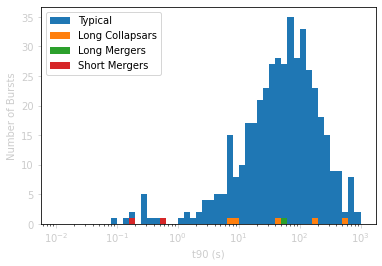

There are 6 known long collapsars, 1 known long mergers, 2 known short mergers, 0 known short collapsars, and 0 known exotic GRBs in the sample.


In [26]:
typical_HR=[]
typical_HR_err=np.zeros((1,2))
typical_t90=[]
typical_t90_err=[]
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
exotic_HR=[]
exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
nbins=51
#
valid_fluences=swift_fluences.drop(index=removals[:-2])
fluence_mask=np.isin(valid_fluences[' 25_50kev '], (" N/A", " N/A ", 0), invert=True)
fluence_available_swift_data=edited_swift_data[fluence_mask]
good_fluences=valid_fluences[fluence_mask]
half_flu_mask=np.isin(good_fluences[' 25_50kev_low '], (" N/A", " N/A ", 0), invert=True)
almost_err_fluences=good_fluences[half_flu_mask]
other_flu_mask=np.isin(almost_err_fluences[' 25_50kev_hi '], (" N/A", " N/A ", 0), invert=True)
complete_err_fluences=almost_err_fluences[other_flu_mask]
lc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Collapsars"])
lc_edited_swift_data=fluence_available_swift_data[lc_mask]
for i in lc_edited_swift_data.index.to_list():
    long_collapsar_HR=np.append(long_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    long_collapsar_t90=np.append(long_collapsar_t90, float(lc_edited_swift_data.at[i, \
                                                                '     T90      ']))
long_collapsar_t90_err=np.where(lc_edited_swift_data[ '   T90_err    '] != 'N/A', \
        lc_edited_swift_data['   T90_err    '], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
sc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Collapsars"])
sc_edited_swift_data=fluence_available_swift_data[sc_mask]
for i in sc_edited_swift_data.index.to_list():
    short_collapsar_HR=np.append(short_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    short_collapsar_t90=np.append(short_collapsar_t90, float(sc_edited_swift_data.at[i, \
                                                                '     T90      ']))
short_collapsar_t90_err=np.where(sc_edited_swift_data[ '   T90_err    '] != 'N/A', \
        sc_edited_swift_data['   T90_err    '], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
lm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Mergers"])
lm_edited_swift_data=fluence_available_swift_data[lm_mask]
for i in lm_edited_swift_data.index.to_list():
    long_merger_HR=np.append(long_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    long_merger_t90=np.append(long_merger_t90, float(lm_edited_swift_data.at[i, \
                                                                '     T90      ']))
long_merger_t90_err=np.where(lm_edited_swift_data[ '   T90_err    '] != 'N/A', \
        lm_edited_swift_data['   T90_err    '], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
sm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Mergers"])
sm_edited_swift_data=fluence_available_swift_data[sm_mask]
for i in sm_edited_swift_data.index.to_list():
    short_merger_HR=np.append(short_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    short_merger_t90=np.append(short_merger_t90, float(sm_edited_swift_data.at[i, \
                                                                '     T90      ']))
short_merger_t90_err=np.where(sm_edited_swift_data[ '   T90_err    '] != 'N/A', \
        sm_edited_swift_data['   T90_err    '], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
exo_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Potentially Exotic"])
exo_edited_swift_data=fluence_available_swift_data[exo_mask]
for i in exo_edited_swift_data.index.to_list():
    exotic_HR=np.append(exotic_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    exotic_t90=np.append(exotic_t90, float(exo_edited_swift_data.at[i, \
                                                                '     T90      ']))
exotic_t90_err=np.where(exo_edited_swift_data[ '   T90_err    '] != 'N/A', \
        exo_edited_swift_data['   T90_err    '], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
typical_edited_swift_data=fluence_available_swift_data[~(lm_mask&lc_mask&sm_mask&sc_mask&\
                                                         exo_mask)]
for i in typical_edited_swift_data.index.to_list():
    typical_HR=np.append(typical_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    typical_t90=np.append(typical_t90, float(typical_edited_swift_data.at[i, \
                                                                '     T90      ']))
typical_t90_err=np.where(typical_edited_swift_data[ '   T90_err    '] != 'N/A', \
        typical_edited_swift_data['   T90_err    '], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
plt.hist(long_collapsar_t90, bins=bins)
plt.hist(long_merger_t90, bins=bins)
#plt.hist(short_collapsar_t90, bins=bins)
plt.hist(short_merger_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in the sample.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))

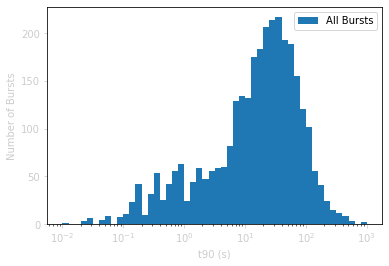

In [8]:
typical_HR=[]
typical_HR_err=np.zeros((1,2))
typical_t90=[]
typical_t90_err=[]
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
exotic_HR=[]
exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
nbins=51
#
# lc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
#                 Known_Precursors["Long Collapsars"])
# lc_edited_swift_data=fluence_available_swift_data[lc_mask]
# for i in lc_edited_swift_data.index.to_list():
#     long_collapsar_HR=np.append(long_collapsar_HR, \
#             float(valid_fluences.at[i, ' 50_100kev '])/\
#                             float(valid_fluences.at[i, ' 25_50kev ']))
#     long_collapsar_t90=np.append(long_collapsar_t90, float(lc_edited_swift_data.at[i, \
#                                                                 '     T90      ']))
# long_collapsar_t90_err=np.where(lc_edited_swift_data[ '   T90_err    '] != 'N/A', \
#         lc_edited_swift_data['   T90_err    '], 0)
# if len(long_collapsar_t90_err)>0:
#     for j in range(0, len(long_collapsar_t90_err)):
#         long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
# sc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
#                 Known_Precursors["Short Collapsars"])
# sc_edited_swift_data=fluence_available_swift_data[sc_mask]
# for i in sc_edited_swift_data.index.to_list():
#     short_collapsar_HR=np.append(short_collapsar_HR, \
#             float(valid_fluences.at[i, ' 50_100kev '])/\
#                             float(valid_fluences.at[i, ' 25_50kev ']))
#     short_collapsar_t90=np.append(short_collapsar_t90, float(sc_edited_swift_data.at[i, \
#                                                                 '     T90      ']))
# short_collapsar_t90_err=np.where(sc_edited_swift_data[ '   T90_err    '] != 'N/A', \
#         sc_edited_swift_data['   T90_err    '], 0)
# if len(short_collapsar_t90_err)>0:
#     for j in range(0, len(short_collapsar_t90_err)):
#         short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
# lm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
#                 Known_Precursors["Long Mergers"])
# lm_edited_swift_data=fluence_available_swift_data[lm_mask]
# for i in lm_edited_swift_data.index.to_list():
#     long_merger_HR=np.append(long_merger_HR, \
#             float(valid_fluences.at[i, ' 50_100kev '])/\
#                             float(valid_fluences.at[i, ' 25_50kev ']))
#     long_merger_t90=np.append(long_merger_t90, float(lm_edited_swift_data.at[i, \
#                                                                 '     T90      ']))
# long_merger_t90_err=np.where(lm_edited_swift_data[ '   T90_err    '] != 'N/A', \
#         lm_edited_swift_data['   T90_err    '], 0)
# if len(long_merger_t90_err)>0:
#     for j in range(0, len(long_merger_t90_err)):
#         long_merger_t90_err[j]=float(long_merger_t90_err[j])
# sm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
#                 Known_Precursors["Short Mergers"])
# sm_edited_swift_data=fluence_available_swift_data[sm_mask]
# for i in sm_edited_swift_data.index.to_list():
#     short_merger_HR=np.append(short_merger_HR, \
#             float(valid_fluences.at[i, ' 50_100kev '])/\
#                             float(valid_fluences.at[i, ' 25_50kev ']))
#     short_merger_t90=np.append(short_merger_t90, float(sm_edited_swift_data.at[i, \
#                                                                 '     T90      ']))
# short_merger_t90_err=np.where(sm_edited_swift_data[ '   T90_err    '] != 'N/A', \
#         sm_edited_swift_data['   T90_err    '], 0)
# if len(short_merger_t90_err)>0:
#     for j in range(0, len(short_merger_t90_err)):
#         short_merger_t90_err[j]=float(short_merger_t90_err[j])
# exo_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
#                 Known_Precursors["Potentially Exotic"])
# exo_edited_swift_data=fluence_available_swift_data[exo_mask]
# for i in exo_edited_swift_data.index.to_list():
#     exotic_HR=np.append(exotic_HR, \
#             float(valid_fluences.at[i, ' 50_100kev '])/\
#                             float(valid_fluences.at[i, ' 25_50kev ']))
#     exotic_t90=np.append(exotic_t90, float(exo_edited_swift_data.at[i, \
#                                                                 '     T90      ']))
# exotic_t90_err=np.where(exo_edited_swift_data[ '   T90_err    '] != 'N/A', \
#         exo_edited_swift_data['   T90_err    '], 0)
# if len(exotic_t90_err)>0:
#     for j in range(0, len(exotic_t90_err)):
#         exotic_t90_err[j]=float(exotic_t90_err[j])
typical_edited_fermi_data=fermi_data
for i in typical_edited_fermi_data.index.to_list():
#     typical_HR=np.append(typical_HR, \
#             float(valid_fluences.at[i, ' 50_100kev '])/\
#                             float(valid_fluences.at[i, ' 25_50kev ']))
    typical_t90=np.append(typical_t90, float(typical_edited_fermi_data.at[i, 't90     ']))
typical_t90_err=np.where(typical_edited_fermi_data['t90_error'] != 'N/A', \
        typical_edited_fermi_data['t90_error'], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
# plt.hist(long_collapsar_t90, bins=bins)
# plt.hist(long_merger_t90, bins=bins)
#plt.hist(short_collapsar_t90, bins=bins)
# plt.hist(short_merger_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['All Bursts'])# 'Long Collapsars', 'Long Mergers', \
#             'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()
# print("There are {} known long collapsars, {} known long \
# mergers, {} known short mergers, {} known short collapsars, and \
# {} known exotic GRBs in the sample.".\
# format(len(long_collapsar_t90), len(long_merger_t90), \
#        len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))

In [9]:
print(fermi_data.columns.to_list())

['name        ', 'ra        ', 'dec      ', 'trigger_time           ', 't90     ', 't90_error', 't90_start', 'fluence   ', 'fluence_error', 'flux_1024  ', 'flux_1024_error', 'flux_1024_time', 'flux_64     ', 'flux_64_error', 'flnc_band_ampl', 'flnc_band_ampl_pos_err', 'flnc_band_ampl_neg_err', 'flnc_band_epeak', 'flnc_band_epeak_pos_err', 'flnc_band_epeak_neg_err', 'flnc_band_alpha', 'flnc_band_alpha_pos_err', 'flnc_band_alpha_neg_err', 'flnc_band_beta', 'flnc_band_beta_pos_err', 'flnc_band_beta_neg_err', 'flnc_spectrum_start', 'flnc_spectrum_stop', 'pflx_best_fitting_model', 'pflx_best_model_redchisq', 'flnc_best_fitting_model', 'flnc_best_model_redchisq', 'trigger_name', 'lii     ', 'bii     ', 'error_radius', 'duration_energy_low', 'duration_energy_high', 'back_interval_low_start', 'back_interval_low_stop', 'back_interval_high_start', 'back_interval_high_stop', 't50     ', 't50_error', 't50_start', 'bcat_detector_mask', 'flu_low', 'flu_high', 'fluence_batse', 'fluence_batse_error', 

In [10]:
##Data conversion##
edited_indices=list(np.where(edited_swift_data.index!=0))
t=Time(edited_swift_data.at[int(edited_swift_data.index[0]),\
                            '       Trig_time_UTC        '].strip(), \
       format='isot', scale='utc')
gorp=t.jd; #honestly at this point I gave up on naming variables
shoes=float(edited_swift_data.at[int(edited_swift_data.index[0]),'  RA_ground   '])
sorks=float(edited_swift_data.at[int(edited_swift_data.index[0]),'     T90      '])
gatorade=float(edited_swift_data.at[int(edited_swift_data.index[0]), ' Image_position_err '])
helmet=float(edited_swift_data.at[int(edited_swift_data.index[0]),'  DEC_ground   '])
nom=str(edited_swift_data.at[int(edited_swift_data.index[0]),'GRBname '].strip())
for i in list(edited_swift_data.index):
    if type(edited_swift_data.at[i,'       Trig_time_UTC        '])==str:
        t=Time(edited_swift_data.at[i,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
        gorp=np.append(gorp, t.jd)
        shoes=np.append(shoes, float(edited_swift_data.at[i,'  RA_ground   ']))
        sorks=np.append(sorks, float(edited_swift_data.at[i,'     T90      ']))
        gatorade=np.append(gatorade, float(edited_swift_data.at[i,' Image_position_err ']))
        helmet=np.append(helmet, float(edited_swift_data.at[i,'  DEC_ground   ']))
        nom=np.append(nom, str(edited_swift_data.at[i,'GRBname '].strip()))
    else :
        gorp=np.append(gorp, 1)
        sorks=np.append(sorks, float(edited_swift_data.at[i,'     T90      ']))
        shoes=np.append(shoes, float(edited_swift_data.at[i,'  RA_ground   ']))
        gatorade=np.append(gatorade, float(edited_swift_data.at[i,' Image_position_err ']))
        helmet=np.append(helmet, float(edited_swift_data.at[i,'  DEC_ground   ']))
        nom=np.append(nom, str(edited_swift_data.at[i,'GRBname '].strip()))
t0=fermi_data.at[0,"trigger_time           "]
t0=re.split("/| |:", t0)
t0 = list(map(int, t0)) 
t0=datetime.datetime(t0[2], t0[0], t0[1], t0[3], t0[4], t0[5], t0[6])
trail_mix = julian.to_jd(t0, fmt='jd') #honestly at this point I gave up on naming variables
soles=fermi_data.at[0,'ra        ']
soles=soles.split(' ')
soles=list(map(float, soles)) 
boots=((soles[0]+(soles[1]+soles[2]/60)/60)*15)
fabric=fermi_data.at[0,'dec      ']
fabric=fabric.split(' ')
fabric=list(map(float, fabric)) 
hat=(fabric[0]+(fabric[1]+fabric[2]/60)/60)
socks=fermi_data.at[0,'t90_error']
w0ter=fermi_data.at[0, 'error_radius']
for i in range(1,len(fermi_data)):
    ti83=fermi_data.at[i,"trigger_time           "]
    ti83=re.split("/| |:", ti83)
    ti83 = list(map(int, ti83)) 
    ti83=datetime.datetime(ti83[2], ti83[0], ti83[1], ti83[3], ti83[4], ti83[5], ti83[6])
    trail_mix = np.append(trail_mix, julian.to_jd(ti83, fmt='jd'))
    soles=fermi_data.at[i,'ra        ']
    soles=soles.split(' ')
    soles=list(map(float, soles)) 
    soles=((soles[0]+(soles[1]+soles[2]/60)/60)*15)
    boots=np.append(boots, soles)
    fabric=fermi_data.at[i,'dec      ']
    fabric=fabric.split(' ')
    fabric=list(map(float, fabric)) 
    fabric=(fabric[0]+(fabric[1]+fabric[2]/60)/60)
    hat=np.append(hat, fabric)
    socks=np.append(socks, fermi_data.at[i,'t90_error'])
    w0ter=np.append(w0ter, fermi_data.at[i,'error_radius'])

In [11]:
##Data conversion fo the redshift data##
start_index=redshift_swift_data.index[0]
t2=Time(redshift_swift_data.at[start_index,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
gorp2=t2.jd; #honestly at this point I gave up on naming variables
shoes2=float(redshift_swift_data.at[start_index,'  RA_ground   '])
sorks2=float(redshift_swift_data.at[start_index,'     T90      '])
gatorade2=float(redshift_swift_data.at[start_index, ' Image_position_err '])
helmet2=float(redshift_swift_data.at[start_index,'  DEC_ground   '])
nom2=str(redshift_swift_data.at[start_index,'GRBname '].strip())
for i in list(redshift_swift_data.index):
    if i !=redshift_swift_data.index[0]:
        if type(redshift_swift_data.at[i,'       Trig_time_UTC        '])==str:
            t2=Time(redshift_swift_data.at[i,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
            gorp2=np.append(gorp2, t2.jd)
            shoes2=np.append(shoes2, float(redshift_swift_data.at[i,'  RA_ground   ']))
            sorks2=np.append(sorks2, float(redshift_swift_data.at[i,'     T90      ']))
            gatorade2=np.append(gatorade2, \
                            float(redshift_swift_data.at[i,' Image_position_err ']))
            helmet2=np.append(helmet2, float(redshift_swift_data.at[i,'  DEC_ground   ']))
            nom2=np.append(nom2, str(redshift_swift_data.at[i,'GRBname '].strip()))
        else:
            gorp2=np.append(gorp2, 1)
            sorks2=np.append(sorks2, float(redshift_swift_data.at[i,'     T90      ']))
            shoes2=np.append(shoes2, float(redshift_swift_data.at[i,'  RA_ground   ']))
            gatorade2=np.append(gatorade2, \
                            float(redshift_swift_data.at[i,' Image_position_err ']))
            helmet2=np.append(helmet2, float(redshift_swift_data.at[i,'  DEC_ground   ']))
            nom2=np.append(nom2, str(redshift_swift_data.at[i,'GRBname '].strip()))
        #Honestly, all the Fermi stuff already existed, so I deleted it
    else:
        continue

In [12]:
##match data##
food = np.zeros((len(trail_mix),len(gorp)))
feet_covers = np.zeros((len(trail_mix),len(gorp)))
UV_protection = np.zeros((len(trail_mix),len(gorp)))
k=0;
for i in range(0, len(gorp)):
    for j in range(0, len(trail_mix)):
        food[j, i] = abs(trail_mix[j]-gorp[i]);
        feet_covers[j, i] = abs(boots[j]-shoes[i]);
        UV_protection[j, i] = abs(hat[j]-helmet[i]);
        if food[j,i]<0.0035:
            if w0ter[j]<0.1:
                if feet_covers[j,i]<3*gatorade[i]:
                    if UV_protection[j,i]<3*gatorade[i]:
                        k=k+1;
            else:
                if feet_covers[j,i]<3*w0ter[j]:
                    if UV_protection[j,i]<3*w0ter[j]:
                        k=k+1;
matches = np.zeros((k+1, 16))
potential_matches=np.zeros((k,3))
print(k)
k=0;
err=0;
special_cases=[]
for i in range(0, len(gorp)):
    for j in range(0, len(trail_mix)):
        if food[j,i]<0.0035: #time
            if w0ter[j]<0.1:
                if feet_covers[j,i]<3*gatorade[i]: #RA
                    if UV_protection[j,i]<3*gatorade[i]: #dec
                        potential_matches[k,0]=food[j,i]
                        potential_matches[k,1]=w0ter[j]
                        potential_matches[k,2]=gatorade[i]
                        name=fermi_data.at[j,"name        "]
                        matches[k,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        matches[k,1] = j
                        matches[k,2] = edited_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade[i] != 0:
                            matches[k,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #alpha
                            matches[k,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #beta
                        else:
                            matches[k,3]='NaN'
                            matches[k,4]='NaN'
                            err=err+1;
                        matches[k,5] = fermi_data.at[j,"t90     "]
                        matches[k,6] = fermi_data.at[j,'flux_256   ']
                        matches[k,7] = fermi_data.at[j,'fluence   ']
                        matches[k,8] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[edited_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            matches[k,9] = swift_fluxes.at[edited_swift_data.index[i],\
                                                               ' 15_350kev ']
                        else:
                            matches[k,9] = 0
                        if swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            matches[k,10] = swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            matches[k,10] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            matches[k,11] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            matches[k,11] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            matches[k,11] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            matches[k,11] = 4
                        else:
                            matches[k,11] = 0
                        #pdb.set_trace()
                        xrt_xcall=np.where(xrt_matches[:,0]==\
                                                 edited_swift_data.index[i-1])[0][0]
                        xrt_call=int(xrt_matches[xrt_xcall, 1])
    #                     matches[k, 11]=xrt_data.at[xrt_call,\
    #                                         'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']
    #                     print(i-1)
    #                     print(xrt_call)
                        if int(xrt_stages[i-1,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                    format(int(xrt_stages[i-1,1]))
                        elif int(xrt_stages[i-1,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                    format(int(xrt_stages[i-1,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
    #                     print(fermi_data.at[j,"name        "])
    #                     print(flux_recall)
    #                     print(more_xrt_data[flux_recall][xrt_call])
                        matches[k, 12]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            matches[k,13]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            matches[k,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            matches[k,13]=headphones[0]
                            matches[k,14]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            matches[k, 13]=more_xrt_data[flux_change][xrt_call]
                            matches[k, 14]=more_xrt_data[flux_change][xrt_call]
                        matches[k,15]=xrt_avg_slope[xrt_xcall, 1]
                        k=k+1
            else:
                if feet_covers[j,i]<3*w0ter[j]: #RA
                    if UV_protection[j,i]<3*w0ter[j]: #dec
                        special_cases=np.append(special_cases,fermi_data.at[j,"name        "])
            
                        potential_matches[k,0]=food[j,i]
                        potential_matches[k,1]=w0ter[j]
                        potential_matches[k,2]=gatorade[i]
                        name=fermi_data.at[j,"name        "]
                        matches[k,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        matches[k,1] = j
                        matches[k,2] = edited_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade[i] != 0:
                            matches[k,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #alpha
                            matches[k,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #beta
                        else:
                            matches[k,3]='NaN'
                            matches[k,4]='NaN'
                            err=err+1;
                        matches[k,5] = fermi_data.at[j,"t90     "]
                        matches[k,6] = fermi_data.at[j,'flux_256   ']
                        matches[k,7] = fermi_data.at[j,'fluence   ']
                        matches[k,8] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[edited_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            matches[k,9] = swift_fluxes.at[edited_swift_data.index[i],\
                                                               ' 15_350kev ']
                        else:
                            matches[k,9] = 0
                        if swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            matches[k,10] = swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            matches[k,10] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            matches[k,11] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            matches[k,11] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            matches[k,11] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            matches[k,11] = 4
                        else:
                            matches[k,11] = 0
                        xrt_xcall=np.where(xrt_matches[:,0]==\
                                                 edited_swift_data.index[i-1])[0][0]
                        xrt_call=int(xrt_matches[xrt_xcall, 1])
                        if int(xrt_stages[i-1,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                    format(int(xrt_stages[i-1,1]))
                        elif int(xrt_stages[i-1,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                    format(int(xrt_stages[i-1,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
                        matches[k, 12]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            matches[k,13]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            matches[k,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            matches[k,13]=headphones[0]
                            matches[k,14]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            matches[k, 13]=more_xrt_data[flux_change][xrt_call]
                            matches[k, 14]=more_xrt_data[flux_change][xrt_call]
                        matches[k,15]=xrt_avg_slope[xrt_xcall, 1]
                        k=k+1
    #                     matches[k,15]=max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call])
    #                     avg_flux=np.where([more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]]==\
    #                             max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]))
    #                     if avg_flux==0:
    #                         matches[k, 16]=more_xrt_data[' d_Ave_obs_flux_WT '][xrt_call]
    #                     elif avg_flux==1:
    #                         matches[k, 16]=more_xrt_data[' d_Ave_obs_flux_PC '][xrt_call]

143


In [13]:
# #redshift_matches
# print(redshift_stages[17,:])

                        
print(special_cases)

['GRB111201599' 'GRB110319815']


In [14]:
##Match the Redshift Data too ##
food_2 = np.zeros((len(trail_mix),len(gorp2)))
feet_covers_2 = np.zeros((len(trail_mix),len(gorp2)))
UV_protection_2 = np.zeros((len(trail_mix),len(gorp2)))
l=0;
for i in range(0, len(gorp2)):
    for j in range(0, len(trail_mix)):
        food_2[j, i] = abs(trail_mix[j]-gorp2[i]);
        feet_covers_2[j, i] = abs(boots[j]-shoes2[i]);
        UV_protection_2[j, i] = abs(hat[j]-helmet2[i]);
        if food_2[j,i]<0.0035:
            if w0ter[j]<0.1:
                if feet_covers_2[j,i]<3*gatorade2[i]:
                    if UV_protection_2[j,i]<3*gatorade2[i]:
                        l=l+1;
            else:
                if feet_covers[j,i]<3*w0ter[j]:
                    if UV_protection[j,i]<3*w0ter[j]:
                        l=l+1;
z_matches = np.zeros((l+1, 17))
z_potential_matches=np.zeros((l,3))
print(l)
l=0;
err=0;
special_cases=[]
for i in range(0, len(gorp2)):
    for j in range(0, len(trail_mix)):
        if food_2[j,i]<0.0035: #time
            if w0ter[j]<0.1:
                if feet_covers_2[j,i]<3*gatorade2[i]: #RA
                    if UV_protection_2[j,i]<3*gatorade2[i]: #dec
                        z_potential_matches[l,0]=food_2[j,i]
                        z_potential_matches[l,1]=w0ter[j]
                        z_potential_matches[l,2]=gatorade2[i]
                        name=fermi_data.at[j,"name        "]
                        z_matches[l,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        z_matches[l,1] = j
                        z_matches[l,2] = redshift_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade2[i] != 0:
                            z_matches[l,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #alpha
                            z_matches[l,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #beta
                        else:
                            z_matches[l,3]='NaN'
                            z_matches[l,4]='NaN'
                            err=err+1;
                        z_matches[l,5] = fermi_data.at[j,"t90     "]
                        z_matches[l,6] = fermi_data.at[j,'flux_256   ']
                        z_matches[l,7] = fermi_data.at[j,'fluence   ']
                        z_matches[l,8] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            z_matches[l,9] = swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev ']
                        else:
                            z_matches[l,9] = 0
                        if swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            z_matches[l,10] = swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            z_matches[l, 10] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            z_matches[l,11] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            z_matches[l,11] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            z_matches[l,11] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            z_matches[l,11] = 4
                        else:
                            z_matches[l,11] = 0
                        #xrt_xcall=np.where(redshift_xrt[:,0]==i)[0][0]
                        xrt_call=int(redshift_xrt[i, 1])
    #                     matches[k, 11]=xrt_data.at[xrt_call,\
    #                                         'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']
    #                     print(i)
    #                     print(xrt_call)
                        if int(redshift_stages[i,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                        elif int(redshift_stages[i,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
    #                     print(fermi_data.at[j,"name        "])
    #                     print(redshift_swift_data.at[redshift_swift_data.index[i], 'GRBname '])
    #                     print(flux_recall)
    #                     print(more_xrt_data[flux_recall][xrt_call])
                        z_matches[l, 12]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            z_matches[l,13]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            z_matches[l,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            z_matches[l,13]=headphones[0]
                            z_matches[l,14]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            z_matches[l, 13]=more_xrt_data[flux_change][xrt_call]
                            z_matches[l, 14]=more_xrt_data[flux_change][xrt_call]
                        z_matches[l,15]=redshift_avg_slope[i, 1]
    #                     z_matches[l,15]=max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call])
    #                     avg_flux=np.where([more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]]==\
    #                             max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]))
    #                     if avg_flux==0:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_WT '][xrt_call]
    #                     elif avg_flux==1:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_PC '][xrt_call]
                        if len(np.where(redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,16] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 0
                        elif len(np.where(other_redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(other_redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,16] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 1
                        l=l+1;
            else:
                if feet_covers_2[j,i]<3*w0ter[j]: #RA
                    if UV_protection_2[j,i]<3*w0ter[j]: #dec
                        special_cases=np.append(special_cases,fermi_data.at[j,"name        "])
                        z_potential_matches[l,0]=food_2[j,i]
                        z_potential_matches[l,1]=w0ter[j]
                        z_potential_matches[l,2]=gatorade2[i]
                        name=fermi_data.at[j,"name        "]
                        z_matches[l,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        z_matches[l,1] = j
                        z_matches[l,2] = redshift_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade2[i] != 0:
                            z_matches[l,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #alpha
                            z_matches[l,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #beta
                        else:
                            z_matches[l,3]='NaN'
                            z_matches[l,4]='NaN'
                            err=err+1;
                        z_matches[l,5] = fermi_data.at[j,"t90     "]
                        z_matches[l,6] = fermi_data.at[j,'flux_256   ']
                        z_matches[l,7] = fermi_data.at[j,'fluence   ']
                        z_matches[l,8] = fermi_data.at[j,'fluence_error']
                        z_matches[l,9] = swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev ']
                        z_matches[l,10] = swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev ']
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            z_matches[l,11] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            z_matches[l,11] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            z_matches[l,11] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            z_matches[l,11] = 4
                        else:
                            z_matches[l,11] = 0
                        #xrt_xcall=np.where(redshift_xrt[:,0]==i)[0][0]
                        xrt_call=int(redshift_xrt[i, 1])
    #                     matches[k, 11]=xrt_data.at[xrt_call,\
    #                                         'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']
    #                     print(i)
    #                     print(xrt_call)
                        if int(redshift_stages[i,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                        elif int(redshift_stages[i,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
    #                     print(fermi_data.at[j,"name        "])
    #                     print(redshift_swift_data.at[redshift_swift_data.index[i], 'GRBname '])
    #                     print(flux_recall)
    #                     print(more_xrt_data[flux_recall][xrt_call])
                        z_matches[l, 12]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            z_matches[l,13]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            z_matches[l,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            z_matches[l,13]=headphones[0]
                            z_matches[l,14]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            z_matches[l, 13]=more_xrt_data[flux_change][xrt_call]
                            z_matches[l, 14]=more_xrt_data[flux_change][xrt_call]
                        z_matches[l,15]=redshift_avg_slope[i, 1]
    #                     z_matches[l,15]=max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call])
    #                     avg_flux=np.where([more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]]==\
    #                             max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]))
    #                     if avg_flux==0:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_WT '][xrt_call]
    #                     elif avg_flux==1:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_PC '][xrt_call]
                        if len(np.where(redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,16] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 0
                        elif len(np.where(other_redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(other_redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,16] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 1
                        l=l+1;
print(special_cases)

54
[]


In [15]:
print(len(z_matches[1,:]))
print(len(['name', 'Fermi row', 'Swift row', 'Type I error', 'Type II error', 't90',\
           'GBM flux', 'GBM fluence', 'Fluence error', 'BAT flux', 'BAT fluence',\
           'Spectral Model','"Plateau" X-Ray Flux', "Pre-X-ray Flux Change",\
           "Post-X-ray Flux Change", "Avg. Temporal Index", 'Likely Redshift']))

17
17


In [16]:
regular_matches=pd.DataFrame(matches, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model',\
                                               '"Plateau" X-Ray Flux', \
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                               "Avg. Temporal Index"])
regular_matches=regular_matches[:-1]
# np.savetxt("Regular_Matches.txt", matches, delimiter=',', \
#            header='name,Fermi row,Swift row,Type I error,Type II error,t90,\
#            GBM flux,GBM fluence,BAT flux,BAT fluence,Spectral Model,\
#            11 Hr X-Ray Flux,BAT Photon Index')
# np.savetxt("regular potential matches.txt", potential_matches)
redshifted_matches=pd.DataFrame(z_matches, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model',\
                                               '"Plateau" X-Ray Flux',\
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                                    "Avg. Temporal Index", 'Likely Redshift'])
redshifted_matches=redshifted_matches[:-1]
# np.savetxt("Redshifted_Matches.txt", z_matches, delimiter=',', \
#            header='Name, Fermi row, Swift row, Type I error, Type II error, t90,\
#            GBM flux, GBM fluence, Fluence error, Spectral Model,"Plateau" X-Ray Flux,\
#            Pre-X-ray Flux Change, Post-X-ray Flux Change, Avg. Temporal Index, \
#            Likely Redshift, Redshift Catalog')
# np.savetxt("Redshifted Potential Matches.txt", z_potential_matches)

In [17]:
typical_data=np.zeros((1,16))
long_merger_data=np.zeros((1,16))
long_collapsar_data=np.zeros((1,16))
short_merger_data=np.zeros((1,16))
short_collapsar_data=np.zeros((1,16))
for i in range(0, len(regular_matches)):
    if edited_swift_data.at[regular_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                    Known_Precursors["Long Collapsars"]:
        long_collapsar_data=np.append(long_collapsar_data, [regular_matches.loc[i].array], axis=0)
    elif edited_swift_data.at[regular_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                     Known_Precursors["Long Mergers"]:
        long_merger_data=np.append(long_merger_data, [regular_matches.loc[i].array], axis=0)
    elif edited_swift_data.at[regular_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                     Known_Precursors["Short Collapsars"]:
        short_collapsar_data=np.append(short_collapsar_data, \
                                       [regular_matches.loc[i].array], axis=0)
    elif edited_swift_data.at[regular_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                     Known_Precursors["Short Mergers"]:
        short_merger_data=np.append(short_merger_data, [regular_matches.loc[i].array], axis=0)
    else:
        typical_data=np.append(typical_data, [regular_matches.loc[i].array], axis=0)
typical_data=pd.DataFrame(typical_data, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model',\
                                               '"Plateau" X-Ray Flux', \
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                               "Avg. Temporal Index"])
short_merger_data=pd.DataFrame(short_merger_data, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model',\
                                               '"Plateau" X-Ray Flux', \
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                               "Avg. Temporal Index"])
short_collapsar_data=pd.DataFrame(short_collapsar_data, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model',\
                                               '"Plateau" X-Ray Flux', \
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                               "Avg. Temporal Index"])
long_merger_data=pd.DataFrame(long_merger_data, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model',\
                                               '"Plateau" X-Ray Flux', \
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                               "Avg. Temporal Index"])
long_collapsar_data=pd.DataFrame(long_collapsar_data, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model',\
                                               '"Plateau" X-Ray Flux', \
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                               "Avg. Temporal Index"])
typical_data=typical_data[:-1]
short_merger_data=short_merger_data[:-1]
short_collapsar_data=short_collapsar_data[:-1]
long_merger_data=long_merger_data[:-1]
long_collapsar_data=long_collapsar_data[:-1]

In [18]:
typical_redshift=np.zeros((1,17))
long_merger_redshift=np.zeros((1,17))
long_collapsar_redshift=np.zeros((1,17))
short_merger_redshift=np.zeros((1,17))
short_collapsar_redshift=np.zeros((1,17))
for i in range(0, len(redshifted_matches)):
    if redshift_swift_data.at[redshifted_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                     Known_Precursors["Long Collapsars"]:
        long_collapsar_redshift=np.append(long_collapsar_redshift, [redshifted_matches.loc[i].array], axis=0)
    elif redshift_swift_data.at[redshifted_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                     Known_Precursors["Long Mergers"]:
        long_merger_redshift=np.append(long_merger_redshift, [redshifted_matches.loc[i].array],\
                                       axis=0)
    elif redshift_swift_data.at[redshifted_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                     Known_Precursors["Short Collapsars"]:
        short_collapsar_redshift=np.append(short_collapsar_redshift, \
                                       [redshifted_matches.loc[i].array], axis=0)
    elif redshift_swift_data.at[redshifted_matches.at[i, 'Swift row'],'GRBname '][3:].strip() in \
                                     Known_Precursors["Short Mergers"]:
        short_merger_redshift=np.append(short_merger_redshift, [redshifted_matches.loc[i].array],\
                                        axis=0)
    else:
        typical_redshift=np.append(typical_redshift, [redshifted_matches.loc[i].array], axis=0)
typical_redshift=pd.DataFrame(typical_redshift, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model',\
                                               '"Plateau" X-Ray Flux',\
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                                    "Avg. Temporal Index",\
                                                         'Likely Redshift'])
short_merger_redshift=pd.DataFrame(short_merger_redshift, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model',\
                                               '"Plateau" X-Ray Flux',\
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                                    "Avg. Temporal Index",\
                                                                   'Likely Redshift'])
short_collapsar_redshift=pd.DataFrame(short_collapsar_redshift, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model',\
                                               '"Plateau" X-Ray Flux',\
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                                    "Avg. Temporal Index",\
                                                            'Likely Redshift'])
long_merger_redshift=pd.DataFrame(long_merger_redshift, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model',\
                                               '"Plateau" X-Ray Flux',\
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                                    "Avg. Temporal Index",\
                                                                 'Likely Redshift'])
long_collapsar_redshift=pd.DataFrame(long_collapsar_redshift, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model',\
                                               '"Plateau" X-Ray Flux',\
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                                    "Avg. Temporal Index", \
                                                                       'Likely Redshift'])
typical_redshift=typical_redshift[:-1]
short_merger_redshift=short_merger_redshift[:-1]
short_collapsar_redshift=short_collapsar_redshift[:-1]
long_merger_redshift=long_merger_redshift[:-1]
long_collapsar_redshift=long_collapsar_redshift[:-1]

In [19]:
#print(regular_matches)
#print(redshifted_matches)
# print(type(redshifted_matches))
#print(redshifted_matches["name"])
# print(redshifted_matches["Pre-X-ray Flux Change"])
# np.transpose(np.column_stack((regular_matches["Pre-X-ray Flux Change"],\
#         np.abs(regular_matches["Post-X-ray Flux Change"]))))

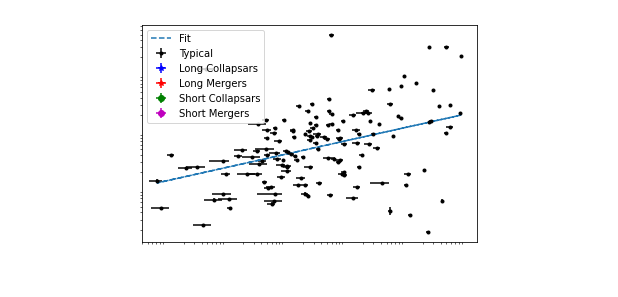

The coffiencents are: Slope=0.2322479614452455 and Intersect=-2.831852150115982


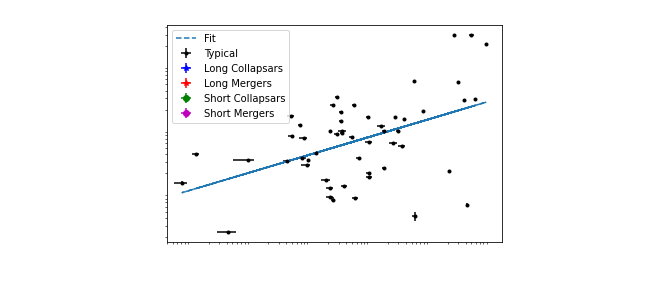

The coffiencents are: Slope=0.2791375231053703 and Intersect=-2.3332347387074357


In [20]:
#these are 211211A, (kilonova, long) 220101A, 221009A, (supernova? long) 230307A 
#(kilonova, long), find some short kilonova, 130603B (tanvir et al. 2013), also some
#known 
#plotting the known central engines to see what 
# plt.scatter(regular_matches['GBM fluence'], \
#             regular_matches['"Plateau" X-Ray Flux'])
# plt.scatter(np.log(regular_matches['GBM fluence'][special_list_regular]), \
#                    np.log(regular_matches['Phase II X-Ray Flux'][special_list_regular]),\
#                   'g*')
# regular_flux_error=np.transpose(np.column_stack((regular_matches["Pre-X-ray Flux Change"],\
#         np.abs(regular_matches["Post-X-ray Flux Change"]))))
typical_flux_error=np.transpose(np.column_stack((typical_data["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(typical_data["Post-X-ray Flux Change"].fillna(0)))))
short_coll_flux_error=np.transpose(np.column_stack((\
                                        short_collapsar_data["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(short_collapsar_data["Post-X-ray Flux Change"].fillna(0)))))
short_merger_flux_error=np.transpose(np.column_stack((short_merger_data["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(short_merger_data["Post-X-ray Flux Change"].fillna(0)))))
long_coll_flux_error=np.transpose(np.column_stack((\
                                        long_collapsar_data["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(long_collapsar_data["Post-X-ray Flux Change"].fillna(0)))))
long_merger_flux_error=np.transpose(np.column_stack((long_merger_data["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(long_merger_data["Post-X-ray Flux Change"].fillna(0)))))
coefficients = np.polyfit(np.log10(regular_matches['"Plateau" X-Ray Flux']), \
                          np.log10(regular_matches['GBM fluence']), 1)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(regular_matches['"Plateau" X-Ray Flux']))
plt.errorbar(x=typical_data['"Plateau" X-Ray Flux'], y=typical_data['GBM fluence'],\
             xerr=typical_flux_error, yerr=typical_data['Fluence error'],
            marker=".", color="k", ls='none')
plt.errorbar(x=short_collapsar_data['"Plateau" X-Ray Flux'],\
             y=short_collapsar_data['GBM fluence'],\
             xerr=short_coll_flux_error, yerr=short_collapsar_data['Fluence error'],
            marker="*", color="b", ls='none')
plt.errorbar(x=long_collapsar_data['"Plateau" X-Ray Flux'],\
             y=long_collapsar_data['GBM fluence'],\
             xerr=long_coll_flux_error, yerr=long_collapsar_data['Fluence error'],
            marker="*", color="r", ls='none')
plt.errorbar(x=short_merger_data['"Plateau" X-Ray Flux'], \
             y=short_merger_data['GBM fluence'],\
             xerr=short_merger_flux_error, yerr=short_merger_data['Fluence error'],
            marker="o", color="g", ls='none')
plt.errorbar(x=long_merger_data['"Plateau" X-Ray Flux'], y=long_merger_data['GBM fluence'],\
             xerr=long_merger_flux_error, yerr=long_merger_data['Fluence error'],
            marker="o", color="m", ls='none')
plt.plot(regular_matches['"Plateau" X-Ray Flux'], 10**log10_y_fit, '--')
plt.xscale('log')
plt.yscale('log')
plt.title('XRT "Plateau" Afterglow Flux v. GBM Prompt Fluence for All Included Bursts',\
          color='white', size=16)
plt.xlabel(r'${F}_{plat, XRT}$ (0.3-10 keV) $(erg*cm^{-2}*s^{-1})$', \
           color='white', size=14)
plt.ylabel(r'${Flu}_{p, GBM}$ (10-$10^3$ keV) $(erg*cm^{-2})$', \
           color='white', size=14)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend(['Fit', 'Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
            'Short Mergers'])
plt.show()
print('The coffiencents are: Slope={} and Intersect={}'.\
format(coefficients[0],coefficients[1]))
# plt.scatter(redshifted_matches['GBM fluence'], \
#             redshifted_matches['"Plateau" X-Ray Flux'])
# redshift_flux_error=np.transpose(np.column_stack((redshifted_matches["Pre-X-ray Flux Change"],\
#         np.abs(redshifted_matches["Post-X-ray Flux Change"]))))
typical_redshift_flux_error=np.transpose(np.column_stack((typical_redshift["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(typical_redshift["Post-X-ray Flux Change"].fillna(0)))))
long_coll_red_flux_error=np.transpose(np.column_stack((long_collapsar_redshift["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(long_collapsar_redshift["Post-X-ray Flux Change"].fillna(0)))))
long_merger_red_flux_error=np.transpose(np.column_stack((long_merger_redshift["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(long_merger_redshift["Post-X-ray Flux Change"].fillna(0)))))
short_coll_red_flux_error=np.transpose(np.column_stack((\
                                        short_collapsar_data["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(short_collapsar_data["Post-X-ray Flux Change"].fillna(0)))))
short_merger_red_flux_error=np.transpose(np.column_stack((short_merger_redshift["Pre-X-ray Flux Change"].fillna(0),\
        np.abs(short_merger_redshift["Post-X-ray Flux Change"].fillna(0)))))
coefficients = np.polyfit(np.log10(redshifted_matches['"Plateau" X-Ray Flux']),\
                          np.log10(redshifted_matches['GBM fluence']), 1)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(redshifted_matches['"Plateau" X-Ray Flux']))
plt.errorbar(typical_redshift['"Plateau" X-Ray Flux'], y=typical_redshift['GBM fluence'],\
             yerr=typical_redshift['Fluence error'], xerr=typical_redshift_flux_error,\
            marker=".", color="k", ls='none')
plt.errorbar(x=short_collapsar_redshift['"Plateau" X-Ray Flux'],\
             y=short_collapsar_redshift['GBM fluence'],\
             xerr=short_coll_red_flux_error, yerr=short_collapsar_redshift['Fluence error'],
            marker="*", color="b", ls='none')
plt.errorbar(x=long_collapsar_redshift['"Plateau" X-Ray Flux'],\
             y=long_collapsar_redshift['GBM fluence'],\
             xerr=long_coll_red_flux_error, yerr=long_collapsar_redshift['Fluence error'],
            marker="*", color="r", ls='none')
plt.errorbar(x=short_merger_redshift['"Plateau" X-Ray Flux'], \
             y=short_merger_redshift['GBM fluence'],\
             xerr=short_merger_red_flux_error, yerr=short_merger_redshift['Fluence error'],
            marker="o", color="g", ls='none')
plt.errorbar(x=long_merger_redshift['"Plateau" X-Ray Flux'], y=long_merger_redshift['GBM fluence'],\
             xerr=long_merger_red_flux_error, yerr=long_merger_redshift['Fluence error'],
            marker="o", color="m", ls='none')
plt.plot(redshifted_matches['"Plateau" X-Ray Flux'], 10**log10_y_fit, '--')
plt.legend(['Fit', 'Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
            'Short Mergers'])
# plt.scatter(np.log(regular_matches['GBM fluence'][special_list_redshifted]), \
#                    np.log(regular_matches['Phase II X-Ray Flux'][special_list_redshifted]),\
#                    'g*')
plt.title('XRT "Plateau" Afterglow Flux versus GBM Prompt Fluence for Bursts with Redshift',\
          color='white', size=16)
plt.xlabel(r'${F}_{plat, XRT}$ (0.3-10 keV) $(erg*cm^{-2}*s^{-1})$', \
           color='white', size=14)
plt.ylabel(r'${Flu}_{p, GBM}$ (10-$10^3$ keV) $(erg*cm^{-2})$', \
           color='white', size=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()
print('The coffiencents are: Slope={} and Intersect={}'.\
format(coefficients[0],coefficients[1]))

In [21]:
regular_subtractions=np.where(regular_matches['Avg. Temporal Index']==0)[0]
last_minute_idea=regular_matches.drop(index=regular_subtractions)
typical_subs=np.where(typical_data['Avg. Temporal Index']==0)[0]
last_minute_typical=typical_data.drop(index=typical_subs)
long_coll_subs=np.where(long_collapsar_data['Avg. Temporal Index']==0)[0]
last_minute_long_coll=long_collapsar_data.drop(index=long_coll_subs)
long_merger_subs=np.where(long_merger_data['Avg. Temporal Index']==0)[0]
last_minute_long_merger=long_merger_data.drop(index=long_merger_subs)
short_coll_subs=np.where(short_collapsar_data['Avg. Temporal Index']==0)[0]
last_minute_short_coll=short_collapsar_data.drop(index=short_coll_subs)
short_merger_subs=np.where(short_merger_data['Avg. Temporal Index']==0)[0]
last_minute_short_merger=short_merger_data.drop(index=short_merger_subs)
#
redshifted_subtractions=np.where(redshifted_matches['Avg. Temporal Index']==0)[0]
other_idea=redshifted_matches.drop(index=redshifted_subtractions)
typical_other_subs=np.where(typical_redshift['Avg. Temporal Index']==0)[0]
other_typical=typical_redshift.drop(index=typical_other_subs)
long_coll_other_subs=np.where(long_collapsar_redshift['Avg. Temporal Index']==0)[0]
other_long_coll=long_collapsar_redshift.drop(index=long_coll_other_subs)
long_merger_other_subs=np.where(long_merger_redshift['Avg. Temporal Index']==0)[0]
other_long_merger=long_merger_redshift.drop(index=long_merger_other_subs)
short_coll_other_subs=np.where(short_collapsar_redshift['Avg. Temporal Index']==0)[0]
other_short_coll=short_collapsar_redshift.drop(index=short_coll_other_subs)
short_merger_other_subs=np.where(short_merger_redshift['Avg. Temporal Index']==0)[0]
other_short_merger=short_merger_redshift.drop(index=short_merger_other_subs)

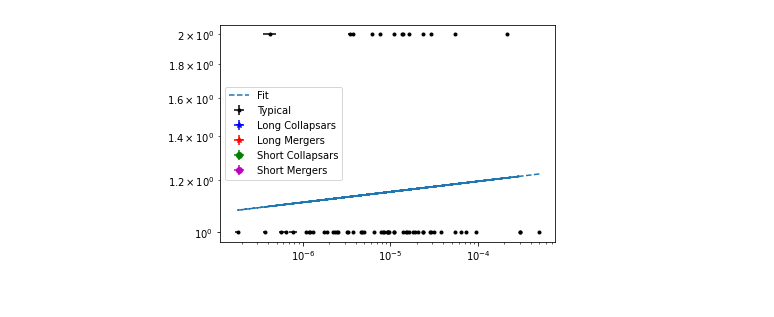

The coffiencents are: Slope=0.016013409319323154 and Intersect=0.14141889052498008


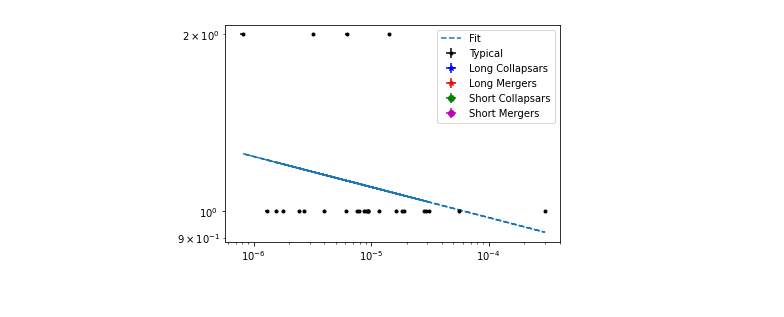

The coffiencents are: Slope=-0.05207128001960869 and Intersect=-0.2193690432204779


In [22]:
coefficients = np.polyfit(np.log10(last_minute_idea['GBM fluence']),\
                          np.log10(last_minute_idea['Avg. Temporal Index']), 1)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(last_minute_idea['GBM fluence']))
# plt.errorbar(x=last_minute_idea['GBM fluence'], y=last_minute_idea['Avg. Temporal Index'],\
#              xerr=last_minute_idea['Fluence error'], \
#              yerr=np.zeros(len(last_minute_idea)),
#             marker="o", ls='none')
plt.errorbar(last_minute_typical['GBM fluence'], \
             y=last_minute_typical['Avg. Temporal Index'],\
             xerr=last_minute_typical['Fluence error'], \
             yerr=np.zeros(len(last_minute_typical)),\
            marker=".", color="k", ls='none')
plt.errorbar(last_minute_short_coll['GBM fluence'], \
             y=last_minute_short_coll['Avg. Temporal Index'],\
             xerr=last_minute_short_coll['Fluence error'], \
             yerr=np.zeros(len(last_minute_short_coll)),\
            marker="*", color="b", ls='none')
plt.errorbar(last_minute_long_coll['GBM fluence'], \
             y=last_minute_long_coll['Avg. Temporal Index'],\
             xerr=last_minute_long_coll['Fluence error'], \
             yerr=np.zeros(len(last_minute_long_coll)),\
            marker="*", color="r", ls='none')
plt.errorbar(last_minute_short_merger['GBM fluence'], \
             y=last_minute_short_merger['Avg. Temporal Index'],\
             xerr=last_minute_short_merger['Fluence error'], \
             yerr=np.zeros(len(last_minute_short_merger)),\
            marker="o", color="g", ls='none')
plt.errorbar(last_minute_long_merger['GBM fluence'], \
             y=last_minute_long_merger['Avg. Temporal Index'],\
             xerr=last_minute_long_merger['Fluence error'], \
             yerr=np.zeros(len(last_minute_long_merger)),\
            marker="o", color="m", ls='none')
plt.plot(last_minute_idea['GBM fluence'], 10**log10_y_fit, '--')
plt.legend(['Fit', 'Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
            'Short Mergers'])
plt.xscale('log')
plt.yscale('log')
plt.title('The GBM Prompt Fluence versus Average XRT Afterglow Temporal Index for All Included Bursts',\
          color='white', size=16)
plt.xlabel('Fermi-GBM prompt fluence,\n'+r'10-1000 keV, $\frac{erg}{cm^2}$', \
           color='white', size=14)
plt.ylabel('Average Swift-XRT Temporal Index,\n'+r'0.3-10 keV, $\frac{1}{s}$', \
           color='white', size=14)
plt.show()
print('The coffiencents are: Slope={} and Intersect={}'.\
format(coefficients[0],coefficients[1]))

coefficients = np.polyfit(np.log10(other_idea['GBM fluence']),\
                          np.log10(other_idea['Avg. Temporal Index']), 1)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(other_idea['GBM fluence']))
# plt.errorbar(other_idea['GBM fluence'], y=other_idea['Avg. Temporal Index'],\
#              xerr=other_idea['Fluence error'], \
#              yerr=np.zeros(len(other_idea)), marker="o", ls='none')
plt.errorbar(other_typical['GBM fluence'], \
             y=other_typical['Avg. Temporal Index'],\
             xerr=other_typical['Fluence error'], \
             yerr=np.zeros(len(other_typical)),\
            marker=".", color="k", ls='none')
plt.errorbar(other_short_coll['GBM fluence'], \
             y=other_short_coll['Avg. Temporal Index'],\
             xerr=other_short_coll['Fluence error'], \
             yerr=np.zeros(len(other_short_coll)),\
            marker="*", color="b", ls='none')
plt.errorbar(other_long_coll['GBM fluence'], \
             y=other_long_coll['Avg. Temporal Index'],\
             xerr=other_long_coll['Fluence error'], \
             yerr=np.zeros(len(other_long_coll)),\
            marker="*", color="r", ls='none')
plt.errorbar(other_short_merger['GBM fluence'], \
             y=other_short_merger['Avg. Temporal Index'],\
             xerr=other_short_merger['Fluence error'], \
             yerr=np.zeros(len(other_short_merger)),\
            marker="o", color="g", ls='none')
plt.errorbar(other_long_merger['GBM fluence'], \
             y=other_long_merger['Avg. Temporal Index'],\
             xerr=other_long_merger['Fluence error'], \
             yerr=np.zeros(len(other_long_merger)),\
            marker="o", color="m", ls='none')
plt.plot(other_idea['GBM fluence'], 10**log10_y_fit, '--')
plt.legend(['Fit', 'Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
            'Short Mergers'])
# plt.scatter(np.log(regular_matches['GBM fluence'][special_list_redshifted]), \
#                    np.log(regular_matches['Phase II X-Ray Flux'][special_list_redshifted]),\
#                    'g*')
plt.title('The GBM Prompt Fluence versus Average XRT Afterglow Temporal Index for Bursts with Redshift',\
          color='white', size=16)
plt.xlabel('Fermi-GBM prompt fluence,\n'+r'10-1000 keV, $\frac{erg}{cm^2}$', \
           color='white', size=14)
plt.ylabel('Average Swift-XRT flux,\n'+r'0.3-10 keV, $\frac{1}{s}$', \
           color='white', size=14)
plt.xscale('log')
plt.yscale('log')
plt.show()
print('The coffiencents are: Slope={} and Intersect={}'.\
format(coefficients[0],coefficients[1]))

In [23]:
# elif edited_swift_data.at[i,'GRBname '][3:].strip() == \
#         Known_Precursors["Short Collapsars"]:
#             short_collapsar_HR=np.append(short_collapsar_HR, float(swift_fluences.at[i, \
#                                 ' 50_100kev '])/float(swift_fluences.at[i,' 25_50kev ']))
#             short_collapsar_t90=np.append(short_collapsar_t90, \
#                                           swift_data.at[i, '     T90      '])
#             if swift_fluences.at[i,' 25_50kev_low '] !=' N/A ' and \
#             swift_fluences.at[i, ' 25_50kev_hi '] != ' N/A ':
#                 HR_err=[[np.sqrt(float(swift_fluences.at[i, ' 50_100kev_low '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i,' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_low '])**2)/\
#                                  float(swift_fluences.at[i,' 25_50kev '])**4),\
#                              np.sqrt(float(swift_fluences.at[i,' 50_100kev_hi '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i, ' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_hi '])**2)/\
#                                      float(swift_fluences.at[i,' 25_50kev '])**4)]]
#                 short_collapsar_HR_err=np.append(short_collapsar_HR_err, HR_err, axis=0)
#             else:
#                 short_collapsar_HR_err=np.append(short_collapsar_HR_err,[[0, 0]], axis=0)
#             if swift_data.at[i, '   T90_err    '] != 'N/A':
#                 short_collapsar_t90_err=np.append(short_collapsar_t90_err, \
#                                                   swift_data.at[i, '   T90_err    '])
#             else:
#                 short_collapsar_t90_err=np.append(short_collapsar_t90_err, 0)
#         elif edited_swift_data.at[i,'GRBname '][3:].strip() in \
#                                          Known_Precursors["Long Mergers"]:
#             long_merger_HR=np.append(long_merger_HR, float(swift_fluences.at[i, \
#                                 ' 50_100kev '])/float(swift_fluences.at[i,' 25_50kev ']))
#             long_merger_t90=np.append(long_merger_t90, swift_data.at[i, '     T90      '])
#             if swift_fluences.at[i,' 25_50kev_low '] !=' N/A ' and \
#             swift_fluences.at[i, ' 25_50kev_hi '] != ' N/A ':
#                 HR_err=[[np.sqrt(float(swift_fluences.at[i, ' 50_100kev_low '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i,' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_low '])**2)/\
#                                  float(swift_fluences.at[i,' 25_50kev '])**4),\
#                              np.sqrt(float(swift_fluences.at[i,' 50_100kev_hi '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i, ' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_hi '])**2)/\
#                                      float(swift_fluences.at[i,' 25_50kev '])**4)]]
#                 long_merger_HR_err=np.append(long_merger_HR_err, HR_err, axis=0)
#             else:
#                 long_merger_HR_err=np.append(long_merger_HR_err,[[0, 0]], axis=0)
#             if swift_data.at[i, '   T90_err    '] != 'N/A':
#                 long_merger_t90_err=np.append(long_merger_t90_err,\
#                                               swift_data.at[i, '   T90_err    '])
#             else:
#                 long_merger_t90_err=np.append(long_merger_t90_err, 0)
#         elif edited_swift_data.at[i,'GRBname '][3:].strip() in \
#         Known_Precursors["Short Mergers"]:
#             short_merger_HR=np.append(short_merger_HR, float(swift_fluences.at[i, \
#                                 ' 50_100kev '])/float(swift_fluences.at[i,' 25_50kev ']))
#             short_merger_t90=np.append(short_merger_t90, swift_data.at[i, '     T90      '])
#             if swift_fluences.at[i,' 25_50kev_low '] !=' N/A ' and \
#             swift_fluences.at[i, ' 25_50kev_hi '] != ' N/A ':
#                 HR_err=[[np.sqrt(float(swift_fluences.at[i, ' 50_100kev_low '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i,' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_low '])**2)/\
#                                  float(swift_fluences.at[i,' 25_50kev '])**4),\
#                              np.sqrt(float(swift_fluences.at[i,' 50_100kev_hi '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i, ' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_hi '])**2)/\
#                                      float(swift_fluences.at[i,' 25_50kev '])**4)]]
#                 short_merger_HR_err=np.append(short_merger_HR_err, HR_err, axis=0)
#             else:
#                 short_merger_HR_err=np.append(short_merger_HR_err,[[0, 0]], axis=0)
#             if swift_data.at[i, '   T90_err    '] != 'N/A':
#                 short_merger_t90_err=np.append(short_merger_t90_err, \
#                                                swift_data.at[i, '   T90_err    '])
#             else:
#                 short_merger_t90_err=np.append(short_merger_t90_err, 0)
#         else:
#             typical_HR=np.append(typical_HR, float(swift_fluences.at[i, \
#                                 ' 50_100kev '])/float(swift_fluences.at[i,' 25_50kev ']))
#             typical_t90=np.append(typical_t90, swift_data.at[i, '     T90      '])
#             if swift_fluences.at[i,' 25_50kev_low '] !=' N/A ' and \
#             swift_fluences.at[i, ' 25_50kev_hi '] != ' N/A ':
#                 HR_err=[[np.sqrt(float(swift_fluences.at[i, ' 50_100kev_low '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i,' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_low '])**2)/\
#                                  float(swift_fluences.at[i,' 25_50kev '])**4),\
#                              np.sqrt(float(swift_fluences.at[i,' 50_100kev_hi '])**2\
#                                      /float(swift_fluences.at[i,' 25_50kev '])**2\
#                 +(float(swift_fluences.at[i, ' 50_100kev '])**2*\
#                   float(swift_fluences.at[i,' 25_50kev_hi '])**2)/\
#                                      float(swift_fluences.at[i,' 25_50kev '])**4)]]
#                 typical_HR_err=np.append(typical_HR_err, HR_err, axis=0)
#             else:
#                 typical_HR_err=np.append(typical_HR_err,[[0, 0]], axis=0)
#             if swift_data.at[i, '   T90_err    '] != 'N/A':
#                 typical_t90_err=np.append(typical_t90_err, \
#                                                swift_data.at[i, '   T90_err    '])
#             else:
#                 typical_t90_err=np.append(typical_t90_err, 0)
# typical_HR_err=typical_HR_err[1:]
# long_collapsar_HR_err=long_collapsar_HR_err[1:]
# short_collapsar_HR_err=short_collapsar_HR_err[1:]
# long_merger_HR_err=long_merger_HR_err[1:]
# short_merger_HR_err=short_merger_HR_err[1:]
# nbins=51
# plt.hist(typical_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.hist(long_collapsar_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.hist(long_merger_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.hist(short_collapsar_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.hist(short_merger_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.xscale('log')
# plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
#             'Short Mergers'])
# plt.tick_params(axis='x', colors='0.8')
# plt.tick_params(axis='y', colors='0.8')
# plt.xlabel("t90 (s)", color='0.8', size=14)
# plt.ylabel("Number of Bursts", color='0.8', size=14)
# plt.show()
# plt.hist(long_collapsar_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.hist(long_merger_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.hist(short_collapsar_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.hist(short_merger_t90, np.logspace(np.log10(0.01),np.log10(1000), nbins))
# plt.legend(['Long Collapsars', 'Long Mergers', 'Short Collapsars', \
#             'Short Mergers'])
# plt.xscale('log')
# plt.tick_params(axis='x', colors='0.8')
# plt.tick_params(axis='y', colors='0.8')
# plt.xlabel("t90 (s)", color='0.8', size=14)
# plt.ylabel("Number of Bursts", color='0.8', size=14)
# plt.show()
# plt.errorbar(x=typical_t90, y=typical_HR,\
# # yerr=np.transpose(typical_HR_err), xerr=typical_t90_err,\
#                                                    marker=".", color='k', ls='none')
# plt.errorbar(x=long_collapsar_t90, y=long_collapsar_HR,\
# #              yerr=np.transpose(long_collapsar_HR_err), xerr=long_collapsar_t90_err,\
#                                                                     marker="o", ls='none')
# plt.errorbar(x=long_merger_t90, y=long_merger_HR,\
# #              yerr=np.transpose(long_merger_HR_err), xerr=long_merger_t90_err,\
#                                                                     marker="*", ls='none')
# plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR,\
# #              yerr=np.transpose(short_collapsar_HR_err), xerr=short_collapsar_t90_err,\
#                                                                     marker="^", ls='none')
# plt.errorbar(x=short_merger_t90, y=short_merger_HR,\
# #              yerr=np.transpose(short_merger_HR_err), xerr=short_merger_t90_err,\
#                                                                     marker="+", ls='none')
# # plt.axis([0, 300, 0, 300])
# plt.xscale('log')
# plt.yscale('log')
# # plt.plot(redshifted_matches['"Plateau" X-Ray Flux'], 10**log10_y_fit, '--')
# # # plt.scatter(np.log(regular_matches['GBM fluence'][special_list_redshifted]), \
# # #                    np.log(regular_matches['Phase II X-Ray Flux'][special_list_redshifted]),\
# # #                    'g*')
# # plt.title('XRT "Prompt" Afterglow Flux versus GBM Prompt Fluence for Bursts with Redshift',\
# #           color='white', size=16)
# # plt.xlabel(r'${F}_{plat, XRT}$ (0.3-10 keV) $(erg*cm^{-2}*s^{-1})$', \
# #            color='white', size=14)
# # plt.ylabel(r'${Flu}_{p, GBM}$ (10-$10^3$ keV) $(erg*cm^{-2})$', \
# #            color='white', size=14)
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.xlabel("t90 (s)", color='0.8', size=14)
# plt.ylabel("Hardness Ratio of Bursts", color='0.8', size=14)
# plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
#             'Short Mergers'])
# plt.show()
# # print('The coffiencents are: Slope={} and Intersect={}'.\
# # format(coefficients[0],coefficients[1]))
# counts, bins=np.histogram(typical_t90)
# plt.bar(counts, bins)

[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03]


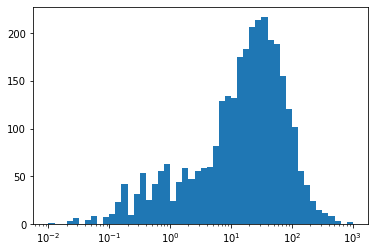

In [24]:
t90=[]
for i in range(len(typical_t90)):
    t90.append(float(typical_t90[i]))
#counts, bins=np.histogram(t90,bins=np.logspace(np.log10(0.01),np.log10(1000), nbins))
#print(counts,bins)
#print(len(bins))
#plt.bar(bins[:-1],counts)
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
print(bins)
plt.hist(t90,bins=bins)
plt.xscale('log')

In [25]:
# value1=singly_broken_PL(1, 2, 0.75, -0.7, 0, 121)
# value2=doubly_broken_PL(1, 2, 4, 0.75, -0.7, -2, 0, 121)
# value3=triply_broken_PL(1, 2, 4, 7, 0.75, -0.7, -2, 1, 0, 121)
# value4=quadruply_broken_PL(1, 2, 4, 7, 12, 0.75, -0.7, -2, 1, -3.5, 0, 121)
# value5=quintuply_broken_PL(1, 2, 4, 7, 12, 24, 0.75, -0.7, -2, 1, -3.5, np.pi, 0, 121)
# print(value1)
# print(value2)
# print(value3)
# print(value4)
# print(value5)
# for i in range(0, 11):
#     print('the count is: {}, and the row is {}'.format(i, regular_matches.at[i, 'Swift row']))
print(max(typical_t90))
print(min(typical_t90))
# print(max(long_collapsar_t90))
# print(max(long_merger_t90))
# #print(max(short_collapsar_t90))
# print(max(short_merger_t90))
# print(max(typical_HR))
# print(min(typical_HR))
#print(np.logspace(np.log10(0.1),np.log10(300), 100))
print(short_collapsar_redshift["Flux"])

984.08
0.0


KeyError: 'Flux'

In [ ]:
x=[]
y1=[]
y2=[]
y3=[]
y4=[]
y5=[]
j=0
i=0
while i<10**9:
    j=j+1
    if i<10**1:
        x=np.append(x,0.1*j)
        i=i+0.1
    elif i<10**2:
        x=np.append(x,1*j)
        i=i+1
    elif i<10**3:
        x=np.append(x,10*j)
        i=i+10
    elif i<10**4:
        x=np.append(x,10**2*j)
        i=i+10**2
    elif i<10**5:
        x=np.append(x,10**3*j)
        i=i+10**3
    elif i<10**6:
        x=np.append(x,10**4*j)
        i=i+10**4
    elif i<10**7:
        x=np.append(x,10**5*j)
        i=i+10**5
    elif i<10**8:
        x=np.append(x,10**6*j)
        i=i+10**6
    else:
        x=np.append(x,10**7*j)
        i=i+10**7
    y1=np.append(y1, singly_broken_PL(1, 150, 4, -0.5, 0, x[j-1]))
    y2=np.append(y2, doubly_broken_PL(1, 150, 1800, 4, -0.5, -1, 0, x[j-1]))
    y3=np.append(y3, triply_broken_PL(1, 150, 1800, 2400, 4, -0.5, -1, -3, 0, x[j-1]))
    y4=np.append(y4, quadruply_broken_PL(1, 150, 1800, 2400, 2.8e6, 4, -0.5, -1, -3, -5, 0,\
                                     x[j-1]))
    y5=np.append(y5, quintuply_broken_PL(1, 150, 1800, 2400, 2.8e6, 3e8, 4, -0.5, -1, -3,\
                                         -5, -10, 0, x[j-1]))
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.plot(x,y5)
plt.legend(['BPL', 'Dual BPL', 'Triple BPL', '4 BPL', '5 BPL'])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.title('Demonstration Plot of Models for the Afterglow in XRT with 1-5 Temporal Breaks',\
          color='0.8', size=16)
plt.xlabel(r'Time (s)', \
           color='0.8', size=14)
plt.ylabel(r'Modeled Count Rate ($s^{-1}$)', \
           color='0.8', size=14)
plt.show()

In [ ]:
print(temporal_indices)
usable_indices=np.where(temporal_indices!=-100)[0]
print(usable_indices)
print(len(usable_indices))
print(len(usable_indices)>=1)

In [ ]:
x=[]
y3=[]
j=0
i=0
while i<10**6:
    j=j+1
    if i<10**1:
        x=np.append(x,0.1*j)
        i=i+0.1
    elif i<10**2:
        x=np.append(x,1*j)
        i=i+1
    elif i<10**3:
        x=np.append(x,10*j)
        i=i+10
    elif i<10**4:
        x=np.append(x,10**2*j)
        i=i+10**2
    elif i<10**5:
        x=np.append(x,10**3*j)
        i=i+10**3
    elif i<10**6:
        x=np.append(x,10**4*j)
        i=i+10**4
    elif i<10**7:
        x=np.append(x,10**5*j)
        i=i+10**5
    elif i<10**8:
        x=np.append(x,10**6*j)
        i=i+10**6
    else:
        x=np.append(x,10**7*j)
        i=i+10**7
    y3=np.append(y3, triply_broken_PL(1, 392-100, 483-100, 3*10**4-100, -0.74, -3.1, -1.02, -2.13, 0, x[j-1]))
plt.plot(x,y3)
plt.legend(['Triple BPL'])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.title('Demonstration Plot of Models for the Afterglow in XRT for GRB210807A',\
          color='0.8', size=16)
plt.xlabel(r'Time (s)', \
           color='0.8', size=14)
plt.ylabel(r'Modeled Count Rate ($s^{-1}$)', \
           color='0.8', size=14)
plt.show()

In [ ]:
np.polyfit(np.log10(regular_matches['"Plateau" X-Ray Flux']), np.log10(regular_matches['GBM fluence']), 1)